# First Method of Simulated Moments (MSM) estimation with estimagic

This tutorial shows how to do a Method of Simulated Moments estimation in estimagic. The Method of Simulated Moments (MSM) is a nonlinear estimation principle that is very useful to fit complicated models to data. The only thing that is needed is a function that simulates model outcomes that you observe in some empirical dataset. 

The tutorial uses an example model from [Rick Evans' great tutorial](https://github.com/rickecon/StructEst_W20) on MSM. The model is deliberately simple so we can focus on the mechanics of the MSM estimation. 

Throughout the tutorial we only talk about MSM estimation, however, the more general case of indirect inference estimation works exactly the same way. 


## Steps of MSM estimation

- load empirical data 
- define a function calculate estimation moments on the data 
- calculate the covariance matrix of the empirical moments (with ``get_moments_cov``)
- define a function to simulate moments from the model 
- estimate the model, calculate standard errors, do sensitivity analysis (with ``estimate_msm``)

## Example: Estimating the parameters of a truncated normal distribution

The model we consiter is a truncated normal distribution. The goal is to estimate its parameters from a dataset of grades observed in a macroeconomics class. 

The estimation mechanics are exactly the same for more complicated models. A model is always defined by a function that can take parameters (here: the mean, variance and lower_cutoff and upper_cutoff) and returns a number of simulated moments (mean, variance, soft_min and soft_max of simulated exam points).

In [1]:
import numpy as np
import pandas as pd

from estimagic.config import EXAMPLE_DIR

## Load data

In [2]:
data = pd.read_csv(EXAMPLE_DIR / "exam_points.csv")
data.head(3).append(data.tail(3))

,points
0,275.50
1,351.50
2,346.25
158,112.30
159,130.60
160,60.20


## Define function to calculate moments

Deciding which moments to use in the estimation is the most difficult part of any MSM estimation. 

Below we list the parameters we want to estimate and moments we hope are informative to identify those parameters:

|Moment           | Parameters                   |
|-----------------|------------------------------|
| mean            | mean                         |
| sd              | sd                           |
| min             | lower_trunc                  |
| max             | upper_trunc                  |

Note that such a direct equivalence of moments and parameters is not strictly needed, but it is a good way to think about the problem:

We can also estimate a version where we only use the first two moments or we could include even more moments (like shares that fall into a certain bin of points, as in Rick's original example. In general, more moments are better. 

In [3]:
def calculate_moments(sample, targets="all"):
    points = sample["points"]
    moments = {
        "mean": sample.mean()[0],
        "sd": sample.std()[0],
        "min": sample.min()[0],
        "max": sample.max()[0],
    }
    if targets != "all":
        moments = {k: v for k, v in moments.items() if k in targets}
    moments = pd.Series(moments)
    return moments

In [4]:
empirical_moments = calculate_moments(data)
empirical_moments

mean    341.908696
sd       88.752027
min      17.000000
max     449.800000
dtype: float64

## Calculate the covariance matrix of empirical moments

The covariance matrix of the empirical moments (``moments_cov``) is needed for three things:
1. to calculate the weighting matrix
2. to calculate standard errors
3. to calculate sensitivity measures

We will calculate ``moments_cov`` via a bootstrap. Depending on your problem there can be other ways to do it.

In [5]:
from estimagic import get_moments_cov

In [6]:
moments_cov = get_moments_cov(
    data, calculate_moments, bootstrap_kwargs={"n_draws": 5_000, "seed": 1234}
)
moments_cov

,mean,sd,min,max
mean,50.911106,-41.729674,25.566590,2.128968
sd,-41.729674,57.971623,-42.888101,-0.559551
min,25.566590,-42.888101,209.435179,2.427182
max,2.128968,-0.559551,2.427182,11.929751


``get_moments_cov`` mainly just calls estimagic's bootstrap function. See our [bootstrap_tutorial](../how_to_guides/inference/how_to_do_bootstrap_inference.ipynb) for background information. 



## Define a function to calculate simulated moments

In real application, this is the step that takes most of the time. However, in our very simple case, all the work is already done by scipy.

To test our function let's first set up a parameter vector (which will also serve as start parameters for the numerical optimization). 

In [7]:
params = pd.DataFrame(
    [500, 100, 0, 450],
    index=["mean", "sd", "lower_trunc", "upper_trunc"],
    columns=["value"],
)
params["lower_bound"] = [-np.inf, 0, -np.inf, -np.inf]
params

,value,lower_bound
mean,500,-inf
sd,100,0.0
lower_trunc,0,-inf
upper_trunc,450,-inf


In [8]:
from scipy.stats import truncnorm

In [9]:
def simulate_moments(params, n_draws=1_000, seed=5471):
    np.random.seed(seed)
    pardict = params["value"].to_dict()
    draws = truncnorm.rvs(
        a=(pardict["lower_trunc"] - pardict["mean"]) / pardict["sd"],
        b=(pardict["upper_trunc"] - pardict["mean"]) / pardict["sd"],
        loc=pardict["mean"],
        scale=pardict["sd"],
        size=n_draws,
    )
    sim_data = pd.DataFrame()
    sim_data["points"] = draws

    sim_moments = calculate_moments(sim_data)

    return sim_moments

In [10]:
simulate_moments(params)

mean    384.237035
sd       53.591526
min      66.218431
max     449.943485
dtype: float64

## Estimate the model parameters

Estimating a model means entails the following steps:

- Building a criterion function that measures a distance between simulated and empirical moments
- Minimizing this criterion function.
- Calculating the jacobian of the model
- Calculating standard errors, confidence intervals and p_values
- Calculating sensitivity measures

This can all be done in one go with the ``estimate_msm`` function. This function has good default values, so you only need a minimum number of inputs. However you can configure almost every aspect of the workflow via optional arguments. If you need even more control, you can call the low level functions ``estimate_msm`` is built on directly. 

In [11]:
from estimagic import estimate_msm

In [12]:
res = estimate_msm(
    simulate_moments,
    empirical_moments,
    moments_cov,
    params,
    minimize_options={"algorithm": "scipy_lbfgsb"},
)

In [13]:
res["summary"]

,value,standard_error,p_value,ci_lower,ci_upper,stars
mean,631.876136,260.562274,0.015000,121.183464,1142.568808,**
sd,198.078747,78.486267,0.011379,44.248491,351.909004,**
lower_trunc,16.755053,14.467601,0.241883,-11.600923,45.111030,
upper_trunc,449.887018,3.461443,0.000000,443.102714,456.671321,***


## What's in the result?

The result is a dictionary with the following entries:

In [14]:
res.keys()

dict_keys(['summary', 'cov', 'minimize_res', 'numdiff_info', 'jacobian', 'sensitivity'])

- summary: A DataFrame with estimated parameters, standard errors, p_values and confidence intervals. This is ideal for use with our `estimation_table` function. 
- cov: A DataFrame with the full covariance matrix of the estimated parameters. You can use this for hypothesis tests. 
- minimize_res: A dictionary with the complete output of the numerical optimization (if one was performed)
- numdiff_info: A dictionary with the complete output of the numerical differentiation (if one was performed)
- jacobian: A DataFrame with the jacobian of `simulate_moments` with respect to the free parameters. 
- sensitivity: A dictionary of DataFrames with the six sensitivity measures from Honore, Jorgensen and DePaula (2020)

## How to visualize sensitivity measures

For more background on the sensitivity measures and their interpretation, check out the [how to guide](../how_to_guides/miscellaneous/how_to_visualize_and_interpret_sensitivity_measures.ipynb) on sensitivity measures. 

Here we are just showing you how to plot them:

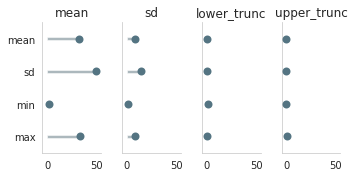

In [15]:
from estimagic.visualization.lollipop_plot import lollipop_plot

lollipop_plot(res["sensitivity"]["sensitivity_to_bias"].abs().T);

## How to deal with calibrated parameters

In many MSM applications, not all parameters are estimated freely. Instead, some of them are calibrated outside of the model. Thus they are fixed during the estimation and no standard errors can be calculated for them. 

To do this in `estimate_msm`, you can use the same constraint syntax you already know from `maximize` and `minimize`. 

For example, in Rick's Tutorial, the cutoffs are fixed to 0 and 450, respectively. This can be expressed as follows:

In [16]:
constraints = [
    {"loc": "lower_trunc", "type": "fixed", "value": 0},
    {"loc": "upper_trunc", "type": "fixed", "value": 450},
]

res_small = estimate_msm(
    simulate_moments,
    empirical_moments,
    moments_cov,
    params,
    minimize_options={"algorithm": "scipy_lbfgsb"},
    constraints=constraints,
)

res_small["summary"]

,value,standard_error,p_value,ci_lower,ci_upper,stars
mean,595.385686,191.591881,0.001849,219.872500,970.898871,***
sd,186.573882,62.541307,0.002795,63.995172,309.152592,***
lower_trunc,0.000000,NaN,NaN,NaN,NaN,NaN
upper_trunc,450.000000,NaN,NaN,NaN,NaN,NaN


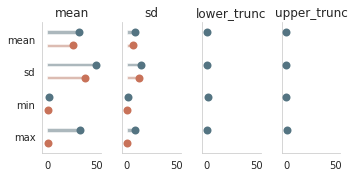

In [17]:
lollipop_plot(
    [
        res["sensitivity"]["sensitivity_to_bias"].abs().T,
        res_small["sensitivity"]["sensitivity_to_bias"].abs().T,
    ]
);

Calculating standard errors, p_values for the constrained model works out of the box. The sensitivity measures for free parameters also work. Showing sensitivity of estimated parameters with respect to calibrated ones does not work yet but is planned soon. If you can't wait, check out Thomas Jorgensen's [Paper](https://arxiv.org/abs/2004.12100) on the topic and make a pull request ;-).

## Comparison with Rick's results

We can compare point estimates and standard errors Rick's Maximum Likelihood and MSM estimates. Note that he fixed the lower and upper truncation points. 

In [18]:
comparison = pd.DataFrame()
comparison["estimagic_free"] = res["minimize_res"]["solution_params"][["value"]].round(
    1
)
comparison["estimagic_fixed"] = res_small["minimize_res"]["solution_params"][
    ["value"]
].round(1)
comparison["rick_mle"] = [622.3, 198.8, 0, 450]
comparison["rick_msm"] = [612.3, 197.3, 0, 450]
comparison

,estimagic_free,estimagic_fixed,rick_mle,rick_msm
mean,631.9,595.4,622.3,612.3
sd,198.1,186.6,198.8,197.3
lower_trunc,16.8,0.0,0.0,0.0
upper_trunc,449.9,450.0,450.0,450.0


Interestingly, the estimates where all parameters are free are closer to the maximum likelihood estimates than the other ones.

Note that we used different estimation moments, so the results are not really comparable. We will do an exact replication soon. 